**Generating Sherlock Holmes Passages Using a Character-Level RNN**

**Yash Potdar**

- Code referenced from [this article](https://notebook.community/spro/practical-pytorch/char-rnn-generation/char-rnn-generation).
  - Code uses Shakespeare dataset, but I use Sherlock Holmes and debugged the code in `train` function.
  - I use their RNN implementation, but add many iterations of architectures using various combinations of hyperparameters.

In [ ]:
# Text file and preprocessing imports
import unidecode
import string
import random
import re

# PyTorch imports
import torch
import torch.nn as nn
from torch.autograd import Variable

# Training time imports
import time
import math

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# General import
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

# Change to Sherlock
file = unidecode.unidecode(open('data/cnus.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 3381982


In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ow of the existence of an
     heir in Canada. In any case he would very soon learn it from his
     friend Dr. Mortimer, and he was told by the latter all details about
     the arrival of Henry Baske


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [ ]:
def random_training_set():    
    chunk = random_chunk()
    #print(chunk)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [ ]:
random_training_set()

(tensor([18, 29, 94, 18, 28, 94, 13, 30, 14, 94, 29, 24, 94, 29, 17, 14, 94, 15,
         10, 12, 29, 96, 94, 94, 94, 94, 94, 29, 17, 10, 29, 94, 44, 94, 17, 10,
         31, 14, 94, 23, 14, 31, 14, 27, 94, 32, 10, 28, 29, 14, 13, 94, 22, 24,
         23, 14, 34, 73, 94, 10, 23, 13, 94, 44, 94, 13, 24, 94, 23, 24, 29, 94,
         25, 27, 24, 25, 24, 28, 14, 94, 29, 24, 94, 11, 14, 16, 18, 23, 94, 29,
         24, 94, 13, 24, 96, 94, 94, 94, 94, 94, 28, 24, 94, 23, 24, 32, 75, 94,
         36, 28, 94, 29, 24, 94, 29, 17, 24, 28, 14, 94, 25, 10, 25, 14, 27, 28,
         94, 32, 18, 29, 17, 94, 32, 17, 18, 12, 17, 94, 34, 24, 30, 94, 10, 27,
         14, 94, 22, 10, 20, 18, 23, 16, 94, 28, 24, 94, 15, 27, 14, 14, 73, 94,
         44, 94, 22, 10, 34, 96, 94, 94, 94, 94, 94, 29, 14, 21, 21, 94, 34, 24,
         30, 94, 29, 17, 10, 29, 94, 18, 23, 94, 12, 10, 28, 14, 94, 29, 17, 14,
         27, 14]),
 tensor([29, 94, 18, 28, 94, 13, 30, 14, 94, 29, 24, 94, 29, 17, 14, 94, 15, 10,
         

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [ ]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def train(inp, target):
    #print(inp)
    #print('\n Target:')
    #print(target)
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        #print(f'output:{output}')
        #print(f'output:{output.shape}')
        #print(f'target:{target[c]}')
        #print(f'target:{target[c].shape}')
        loss += criterion(output, torch.tensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()
    
    #print(loss)
    #print(chunk_len)
    #print(loss.data)
    #print(loss.item())
    return loss.item() / chunk_len

In [ ]:
# plot and summary
print_every = 100
plot_every = 10

**Original hyperparameters**:
- `n_epochs` = 2000
- `hidden_size` = 100
- `n_layers` = 1
- `lr` = 0.005
- `temperature` = 0.8

In [ ]:
# hyperparameters
n_epochs = 2000
hidden_size = 100
n_layers = 1
lr = 0.005
temperature = 0.8

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 12s (100 5%) 2.1818]
Whis saind I foo cned cof ser hith daut theiont, an fer the  in ed cose wernd shis  soort toe oug, "Ad siu there of thi? Wou ny ongif thin ae
        the be sonof frong he so esethaned here owes, sut tou wot mere fo us as nond sin I sast ho souming m,e 

 24s (200 10%) 1.9239]
Wha
     had a thas the hat fromer lares ist and she the the the Mran tand he legte."



      "I itsow the wach of wand thiin noid hee. Are wass theblander, efred onstat he my staught the ores of the
     the the owhe remett the on buid the ars
     t 

 40s (300 15%) 2.0290]
Whitle of thokel, cotetarkite wace of itus it a sere your surtin fur and your ree to stetered be marse wainto leviled a come and lim.

      "Wich kper yurall bee ill cak, and and and is carkn in at has hewher the yourk for and cort mis af the moned it 

 54s (400 20%) 1.6954]
What you way very losed it is phes a grot entand bus may was
      welos
     seent ex shale, he has pach he one was a dome a leary, and in his 

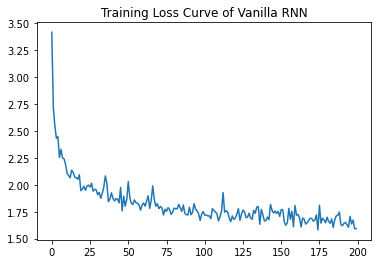

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.title('Training Loss Curve of Vanilla RNN');

In [ ]:
all_losses[-1]

1.592977966308594

**Iteration 1** 

**Changed hyperparameters:**
- `n_epochs` = 2000
- `hidden_size` = 100
- **`n_layers` = 3**
- **`lr` = 0.001**
- `temperature` = 0.8

In [ ]:
# hyperparameters
n_epochs = 2000
hidden_size = 100
n_layers = 3
lr = 0.001
temperature = 0.8

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_1 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_1.append(loss_avg / plot_every)
        loss_avg = 0

 26s (100 5%) 2.9846]
Wh_ e e, thhfh   nal nkt  duum  on hg ooue afeia seao a  r We s et  h i rdtrlrhaao   m  iace  iewa ba
 e
 e. t
 paa  rl      oee sah fgd,cyidadd deipo  ce R rb ctosyn iv  . a a r c   omphsatmet   ahaTefbe ,c  nrlnc
 h  i    ilre maxg nohiiir wao ii ,,n 

 53s (200 10%) 2.6053]
Whey sihe the  hh-e lton bitee alh rasir
  ddis seouni pcites oaicly %ontir, to" age mi
e    afe 
      r
         abe-the tkat tethi rdemodot sendefan
      o ching oge dat detos regat maf lout neslars'l
       denthe an,an.ly net ut uar he esewafror, 

 19s (300 15%) 2.2645]
Wh|
     mround to "feth. thois sos in mat bhe warovanthe t"loe hre wan oce  the hash?. loages the omind aipe ra che hanceold iH,
     thas. iE
     the Rind boI mouse  the to shamith nof and thes anen sor akol" then
     enaddit isod aged
      nouril 

 49s (400 20%) 2.2665]
Whing sroftted, fou" hang o't a uirof a lare pratwe.


     the he cateel, 'I hat susiery we Yand arsttinnen the face wisy who le of couren.


 

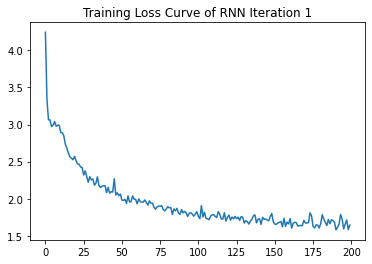

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_1)
plt.title('Training Loss Curve of RNN Iteration 1');

In [ ]:
all_losses_it_1[-1]

1.6461668701171877

**Iteration 2**

**Changed hyperparameters:**
- **`n_epochs` = 4000**
- `hidden_size` = 100
- **`n_layers` = 3**
- **`lr` = 0.001**
- `temperature` = 0.8

In [ ]:
# hyperparameters
n_epochs = 4000
hidden_size = 100
n_layers = 3
lr = 0.001
temperature = 0.8

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_2 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_2.append(loss_avg / plot_every)
        loss_avg = 0

 25s (100 2%) 2.7669]
Whos onllarwnoo  h a.  teohhan ort'hgd cnt  a rolt ae yu sllceeassied pe. toy tar ee h dlsnui lwaoo e  l geme iorspe bin reae" e nntroscare weso tre   wtttt tt, pn eend ao trto Ibt e l pne hti eoeuhta sd ay.t,  eeHn onsot go elt oiaagMioo
w   ee rae rt 

 51s (200 5%) 2.5091]
Whh ane
     sty nind oHe hae ohilt scttis otrghe te esae ootralnnad aetae the eatgaor  ehi aontethivaWae ahtrHe ewthhh sotghen,d mdisthca e. e"d Yenthk. anw os ae iot ain rats ait edl. aw ey. "fesdhwit nrmrneae hmhh. apcns eid s ea aasufadkteeyd herir 

 16s (300 7%) 2.1965]
Whering cifeTeetlteaon uit as the teet aoen un voeslinur pensre thhiceeolet unco tureed ant hy snessn olrhey gan selt coin yhe I
     reled,e wif yo, sauls ok kethiug thh me mevely I dat ars ceites yered rang wotelis sy3etins thor akes tin uim thac" wa 

 42s (400 10%) 2.3157]
Wheet os yoce miur ewes ocered the I the cathet ut whe anln a, hoven the the a lild. I bcat, a I ciinnan I thu."
     diry horder the whiat thoupe

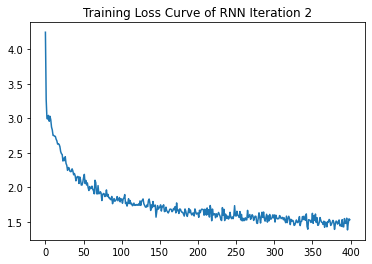

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_2)
plt.title('Training Loss Curve of RNN Iteration 2');

In [ ]:
all_losses_it_2[-1]

1.5283541717529294

**Iteration 3**

**Changed hyperparameters:**
- **`n_epochs` = 3000**
- `hidden_size` = 100
- **`n_layers` = 3**
- `lr` = 0.005
- `temperature` = 0.8

In [ ]:
# hyperparameters
n_epochs = 3000
hidden_size = 100
n_layers = 3
lr = 0.005
temperature = 0.8

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_3 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_3.append(loss_avg / plot_every)
        loss_avg = 0

 26s (100 3%) 2.4396]
Whf thole pned ume ired yltoet oep ien be bnn' the aorinscifer.  heiand yhoce wod onad he ltan tt to roed """ rbt. oure fse wofon cada" twil ichC. " oinre
    "lfouse
    " the 'oorerrir
    "I cfet.  inrsee se ichule ohe 3am the nobt eroukse ue mupeun 

 53s (200 6%) 1.9729]
Whe the thy adt has the wed dot ake age that arith oun, gole Had om mat the
     mind sobisas, of thit he oabt inesis eos hime on the thery the ge ant the the the the ungset se wed anse tut of turdish agiy oich to tot she lame dfyith wor to e coy hare  

 22s (300 10%) 2.0559]
Whong ony wout be sas, poing birion wand is cong ant thouk there mas the aming anteng ise.

     Wand cecintesdescround salily eother with has and-the move fyyy. Ind and cuwinsds astn to bing woup was fising the morner tols ing yory, he cuing stor ithe 

 48s (400 13%) 1.8876]
Whe denare heint a wour and the light the let to iu his the praneft
     he matetare a
     a comed Bneart didoe the
     sas of on uit shin vath

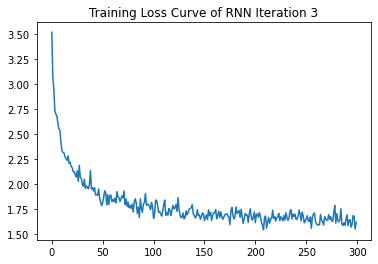

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_3)
plt.title('Training Loss Curve of RNN Iteration 3');

In [ ]:
all_losses_it_3[-1]

1.6212030181884767

**Iteration 4**

**Changed hyperparameters:**
- `n_epochs` = 2000
- **`hidden_size` = 200**
- **`n_layers` = 3**
- `lr` = 0.005
- `temperature` = 0.8

In [ ]:
# hyperparameters
n_epochs = 2000
hidden_size = 200
n_layers = 3
lr = 0.005
temperature = 0.8

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_4 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_4.append(loss_avg / plot_every)
        loss_avg = 0

 39s (100 5%) 2.3280]
Whe, I od rerenyy for anle ofref ftat't.
    lesih
    han fin, mah nes rud tinl han belt avotanses the anu bot he stretis fong hiomis
    un rerint is ond raed sto ind
    thaveg maont mome threr, pyey fof har, thirind tharin relive, of
    tas hen ot 

 20s (200 10%) 2.3584]
Wher mow noone ther becle pear."
      Ive
     in hard he, ard ecave aee fesed ave on of nair
      Wead whe ove ther sale with, yithed av, ad reeand non, als and and in at
     Wolender monet warper and hice o braneed cosyed ruark ant the conenedt, a 

 59s (300 15%) 1.9688]
Wh and Woul kang, the
     ferestene paureson and al and pron neren and fase, the ceantene his and and the wou,  and hing no ugh has fand she sardet and aning on gary of and eblom hingh fule as therne."

     Hon, ann inthe, sixe ning. Dor Mrestaate ot 

 39s (400 20%) 1.9025]
Whally bogly the
     lay we shown ringent the hive shour had in ham the messt shollid bexwider fiilt has son hallnowy the count greach is one g

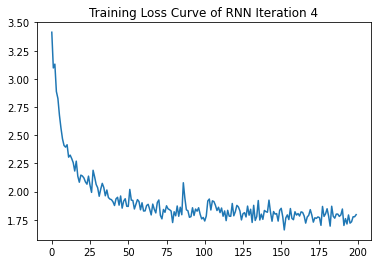

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_4)
plt.title('Training Loss Curve of RNN Iteration 4');

In [ ]:
np.savetxt('losses_iteration4.txt', all_losses_it_4)

In [ ]:
all_losses_it_4[-1]

1.7952188873291015

**Iteration 5**

**Changed hyperparameters:**
- `n_epochs` = 2000
- `hidden_size` = 100
- **`n_layers` = 2**
- `lr` = 0.005
- **`temperature` = 0.5**

In [ ]:
# hyperparameters
n_epochs = 2000
hidden_size = 100
n_layers = 2
lr = 0.005
temperature = 0.5

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_5 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_5.append(loss_avg / plot_every)
        loss_avg = 0

 21s (100 5%) 2.0895]
Whell,.
     htse noreree ceras otand.
     has, ind she fan male imis, she come aben
     relaltil foury an maronund
    "terist are it ume m orles y.
      ror romalen HorWad. hereronun a." ttho mese theft ald omerre the "setet bee as sures ursim the 

 40s (200 10%) 1.9058]
Wher of I whith he
     has "hat an he tato .  the syou the is I
     hiritike ass the ange wall a that thas you
     I wastes he to the a
      wive stionque Men itifaly herild winthill
     ind thare, no wiss
     ill mith As, thas mauthou soghat won 

 0s (300 15%) 1.9559]
Wher.

     "Holulsed
     roween weark the in on he be the he resse thad I mom oo hide me house much the seent ar for see trom an he in oker in her oving her thing word ome to wher undomimeed for sing anded
     by her mame and on ghe jould fead the w 

 21s (400 20%) 1.7728]
Which sarrell, my man slolthio thrugcand of so coplife brout uard. I pruch is lits i srion sound, verolr sice ame ges thout with my starur. I sas

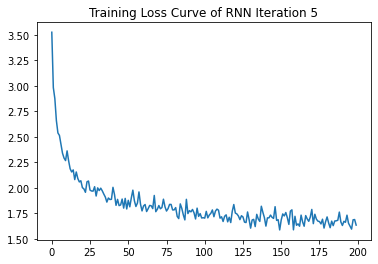

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_5)
plt.title('Training Loss Curve of RNN Iteration 5');

In [ ]:
all_losses_it_5[-1]

1.634117172241211

**Iteration 6**

**Changed hyperparameters:**
- `n_epochs` = 2000
- `hidden_size` = 100
- **`n_layers` = 2**
- `lr` = 0.005
- **`temperature` = 1.5**

In [ ]:
# hyperparameters
n_epochs = 2000
hidden_size = 100
n_layers = 2
lr = 0.005
temperature = 1.5

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_6 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_6.append(loss_avg / plot_every)
        loss_avg = 0

 18s (100 5%) 2.2511]
Wheich hof epry lis hed of forrlawh"
     hat hap ow os whanmeinl a btive urthe, beleercaithay ve. pvelame otumes whid
" "" hever in irhe
      he ftyise he the ie wer. he mesfeergin morond fame lad rethre
     the hanchind in the lie lao skele, hat th 

 37s (200 10%) 1.9902]
Whovef fato lerell ment pwer
     was I beses enely bof yoom fou lanesrle and to sumy thand of and of pone han, whaf
     wan of apatten mal bester whe the sall bedet ungel wat of whuy indert
     fonesisy ant, leacle has lugh wad emlasgy in Brom? has  

 56s (300 15%) 1.7883]
Whardeld had sodeld thy seed om our whin befe
     and then morn, ow bees. Out bu roch tesame hat the fror, and he hour end whher has had the staterned hat the up And hhe have pler
      and the wee here the breolon. Ame sed in had nout preere the jeme 

 17s (400 20%) 1.7847]
Wheres and the
     no he had verelle, hat hold, Amed read fares of that and his my. That nown thed of to qavore whered of the of The
     sinti

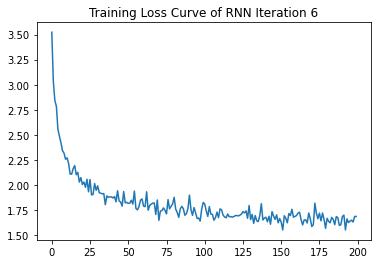

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_6)
plt.title('Training Loss Curve of RNN Iteration 6');

In [ ]:
all_losses_it_6[-1]

1.685931884765625

**Iteration 7**

**Changed hyperparameters:**
- `n_epochs` = 2000
- `hidden_size` = 100
- **`n_layers` = 3**
- `lr` = 0.005
- **`temperature` = 0.5**
- **`chunk_len` = 500**

In [ ]:
# hyperparameters
n_epochs = 2000
hidden_size = 100
n_layers = 3
lr = 0.005
temperature = 0.5
chunk_len = 500

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_it_7 = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 250), '\n')

    if epoch % plot_every == 0:
        all_losses_it_7.append(loss_avg / plot_every)
        loss_avg = 0

 9s (100 5%) 2.3249]
Whetre liulre ohis 't th wet an wan laht it his ta wuraret mo" ned hace sl. powine yocul, wuan tapde Bat sto fe to hobs. wte solou he of wupeves. he. yhe wame wu mens tan the he? wacang ba wat bull he chelsen a med mong, hos
      han musre bat os cota 

 15s (200 10%) 2.0851]
Whes. No
     ooned
  " Noight
  I hough son cot. I theree dung in beortirling catintiok as wus hintut if is a corfher of yhesed disght had onand the
     tand Has on-Whalreteson
     he
     goul there his are ospcodtele misng,

     I afell
     a ba 

 20s (300 15%) 1.9526]
Wh a I piser he there reastifard stend yuws is mundisiung a wus thery ad nbours women oht, ly saed and the of of in a rarss?

     "And, the ighed the
     oner this wousedinishin. I
     Anky moundactoves
     a wtiand then. ich a untind in orineising 

 27s (400 20%) 1.7368]
Wh and sean and ppasineds bletter but the crek of
     and ou the last molsice the shid
     harn. I
     soure
     oun and soursgon with gratly

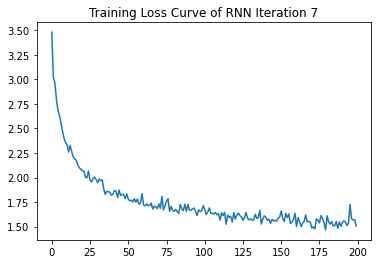

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses_it_7)
plt.title('Training Loss Curve of RNN Iteration 7');

In [ ]:
all_losses_it_7[-1]

1.507133935546875